In [1]:
# set the environment variable for warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# enable autoreload
%load_ext autoreload
%autoreload 2

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

# others
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from copy import deepcopy
import sherpa
from xgboost import XGBRegressor
import sys
import time
from scipy.stats import gamma, norm, beta

# Variables from config file
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES, C_SINGLE, C_INT50, C_INT100, C_GRID, C_COMMON

# util
from util import cross_val_predict_for_nn, sample_station, estimate_epochs, define_model, define_hetero_model_normal

2022-06-01 00:08:41.024912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib


In [5]:
ds_air2m = xr.open_dataset(f"{BASE_DIR}/air.2m.mon.mean.regridded.nc")
ds_air1000_500 = xr.open_dataset(f"{BASE_DIR}/air.1000-500.mon.mean.nc")
ds_hgt500 = xr.open_dataset(f"{BASE_DIR}/hgt500.mon.mean.nc")
ds_hgt1000 = xr.open_dataset(f"{BASE_DIR}/hgt1000.mon.mean.nc")
ds_omega500 = xr.open_dataset(f"{BASE_DIR}/omega500.mon.mean.nc")
ds_pottemp_1000_500 = xr.open_dataset(f"{BASE_DIR}/pottmp.1000-500.mon.mean.nc")
ds_pottemp_1000_850 = xr.open_dataset(f"{BASE_DIR}/pottmp.1000-850.mon.mean.nc")
ds_pwtr = xr.open_dataset(f"{BASE_DIR}/pwtr.mon.mean.nc")
ds_u700 = xr.open_dataset(f"{BASE_DIR}/shum_x_uwnd.700.mon.mean.nc")
ds_u925 = xr.open_dataset(f"{BASE_DIR}/shum_x_uwnd.925.mon.mean.nc")
ds_v700 = xr.open_dataset(f"{BASE_DIR}/shum_x_vwnd.700.mon.mean.nc")
ds_v950 = xr.open_dataset(f"{BASE_DIR}/shum_x_vwnd.925.mon.mean.nc")
ds_shum700 = xr.open_dataset(f"{BASE_DIR}/shum700.mon.mean.nc")
ds_shum925 = xr.open_dataset(f"{BASE_DIR}/shum925.mon.mean.nc")
ds_skt = xr.open_dataset(f"{BASE_DIR}/skt.mon.mean.regridded.nc")
ds_slp = xr.open_dataset(f"{BASE_DIR}/slp.mon.mean.nc")

# ait temperature difference
datasets = [ # list of tuples. (dataset object, attribute string in ds)
    (ds_air2m, "air"), # surface air temperature 2m
    (ds_air1000_500, "air"), # air temperature difference
    (ds_hgt500, "hgt"), # geopotential height (500hPa)
    (ds_hgt1000, "hgt"), # geopotential height (1000hPa)
    (ds_omega500, "omega"), # omega
    (ds_pottemp_1000_500, "pottmp"), # potential temperature difference 1000-500
    (ds_pottemp_1000_850, "pottmp"), # potential temperature fifference 1000-850
    (ds_pwtr, "pr_wtr"), # precipitable water
    (ds_u700, "shum"), # zonal moisture (u) transport
    (ds_u925, "shum"), # zonal moisture (u) transport
    (ds_v700, "shum"), # meridional moisture (v) transport
    (ds_v950, "shum"), # meridional moisture (v) transport
    (ds_shum700, "shum"), # specific humidity: 700 hPa 
    (ds_shum925, "shum"), # specific humidity: 925 hPa
    (ds_skt, "skt"), # skin temperature
    (ds_slp, "slp") # sea level pressure
]
# combine all the cdf data

In [8]:
datasets[12][0]

<xarray.Dataset>
Dimensions:  (lat: 73, level: 1, lon: 144, time: 840)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * level    (level) float32 700.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2017-12-01
Data variables:
    shum     (time, level, lat, lon) float32 ...
Attributes:
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    Conventions:    COARDS
    NCO:            4.2.6
    history:        Sun Aug 26 20:22:35 2018: ncks -O -d level,700.000000 -d ...
    title:          monthly mean shum from the NCEP Reanalysis
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1

In [9]:
df_locations = pd.read_csv(f"{BASE_DIR}/SKNlocations.csv")

In [18]:
df_locations['Lat_DD'].min(), df_locations['Lat_DD'].max()

(18.91367961, 22.23135314)

In [5]:
reanalysis_data = [
    'air2m', 'air1000_500', 'hgt500', 'hgt1000', 'omega500',
    'pottemp1000-500', 'pottemp1000-850', 'pr_wtr', 'shum-uwnd-700',
    'shum-uwnd-925', 'shum-vwnd-700', 'shum-vwnd-950', 'shum700', 'shum925', 
    'skt', 'slp'
]

columns = []
for i in range(6):
    for item in reanalysis_data:
        columns.append(f"{item}_{i}")

columns.extend(['data_in', 'lat', 'lon', 'elevation', 'season_wet', 'season_dry'])
for item in columns:
    print(item, end=' ')

air2m_0 air1000_500_0 hgt500_0 hgt1000_0 omega500_0 pottemp1000-500_0 pottemp1000-850_0 pr_wtr_0 shum-uwnd-700_0 shum-uwnd-925_0 shum-vwnd-700_0 shum-vwnd-950_0 shum700_0 shum925_0 skt_0 slp_0 air2m_1 air1000_500_1 hgt500_1 hgt1000_1 omega500_1 pottemp1000-500_1 pottemp1000-850_1 pr_wtr_1 shum-uwnd-700_1 shum-uwnd-925_1 shum-vwnd-700_1 shum-vwnd-950_1 shum700_1 shum925_1 skt_1 slp_1 air2m_2 air1000_500_2 hgt500_2 hgt1000_2 omega500_2 pottemp1000-500_2 pottemp1000-850_2 pr_wtr_2 shum-uwnd-700_2 shum-uwnd-925_2 shum-vwnd-700_2 shum-vwnd-950_2 shum700_2 shum925_2 skt_2 slp_2 air2m_3 air1000_500_3 hgt500_3 hgt1000_3 omega500_3 pottemp1000-500_3 pottemp1000-850_3 pr_wtr_3 shum-uwnd-700_3 shum-uwnd-925_3 shum-vwnd-700_3 shum-vwnd-950_3 shum700_3 shum925_3 skt_3 slp_3 air2m_4 air1000_500_4 hgt500_4 hgt1000_4 omega500_4 pottemp1000-500_4 pottemp1000-850_4 pr_wtr_4 shum-uwnd-700_4 shum-uwnd-925_4 shum-vwnd-700_4 shum-vwnd-950_4 shum700_4 shum925_4 skt_4 slp_4 air2m_5 air1000_500_5 hgt500_5 hgt1

In [6]:
# load datasets
df_train = pd.read_csv(f"{BASE_DIR}/train.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_valid = pd.read_csv(f"{BASE_DIR}/valid.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_test = pd.read_csv(f"{BASE_DIR}/test.csv", usecols=columns + ['year', 'month', 'skn', 'data_in'])
df_combined = pd.concat([df_train, df_valid, df_test])

In [2]:
from joblib import Parallel, delayed
def process(i):
    return i * i
    
results = Parallel(n_jobs=2)(delayed(process)(i) for i in range(10))
print(results)  # prints [0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [15]:
from multiprocessing import Pool, cpu_count
n_cpu = cpu_count()
def return_random_number(_):
    return np.random.randint(3)
with Pool(n_cpu) as p:
    result = p.map(return_random_number, [_ for _ in range(n_cpu)])
print(result)

[0, 0, 0, 2, 2, 0, 2, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2]


In [32]:
def hello():
    temp = 19
    n_cpu = cpu_count()
    def loop(_):
        return 19
#     def loop(_):
#         print(temp)
    with Pool(n_cpu) as p:
        result = p.map(loop, [_ for _ in range(n_cpu)])
        print(result)
hello()

AttributeError: Can't pickle local object 'hello.<locals>.loop'

In [34]:
[[1,2,3] for _ in range(10)]

[[1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3],
 [1, 2, 3]]

In [42]:
from joblib import Parallel, delayed
def sqrt_func(i, j):
    return i + j
result = Parallel(n_jobs=-1)(delayed(sqrt_func)(i, j) for i in range(5) for j in range(2))


In [43]:
result

[0, 1, 1, 2, 2, 3, 3, 4, 4, 5]

In [15]:
import numpy as np
from sklearn.preprocessing import StandardScaler
def func(X, Y):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    Y = scaler.transform(Y)
    return X, Y
    
X = np.random.random((10,10))
Y = np.random.random((10,10))

In [16]:
X

array([[0.77278497, 0.3523481 , 0.44008981, 0.44132626, 0.74630071,
        0.26041846, 0.6445427 , 0.37371003, 0.60245987, 0.76818882],
       [0.22351023, 0.56613931, 0.97605876, 0.41191462, 0.60281716,
        0.46592501, 0.80463901, 0.20344072, 0.43559862, 0.24372955],
       [0.8808992 , 0.2514928 , 0.27569716, 0.2712373 , 0.77735979,
        0.8186965 , 0.59878394, 0.9547254 , 0.93762773, 0.76537389],
       [0.905788  , 0.72661338, 0.94508593, 0.79022218, 0.58737696,
        0.35757129, 0.7151338 , 0.2031919 , 0.18484327, 0.54981129],
       [0.28793288, 0.03955429, 0.77359109, 0.03490754, 0.6811471 ,
        0.06922893, 0.6925942 , 0.05142748, 0.25145844, 0.85500327],
       [0.60790958, 0.35081524, 0.22201916, 0.32241246, 0.82647519,
        0.39572965, 0.42907647, 0.16655156, 0.33024554, 0.36269539],
       [0.53498888, 0.86188524, 0.46927766, 0.4162485 , 0.32442874,
        0.68898393, 0.58763007, 0.30337506, 0.65304007, 0.04284047],
       [0.03659361, 0.33176209, 0.6835159

In [17]:
A, B = func(X,Y)

In [18]:
X

array([[0.77278497, 0.3523481 , 0.44008981, 0.44132626, 0.74630071,
        0.26041846, 0.6445427 , 0.37371003, 0.60245987, 0.76818882],
       [0.22351023, 0.56613931, 0.97605876, 0.41191462, 0.60281716,
        0.46592501, 0.80463901, 0.20344072, 0.43559862, 0.24372955],
       [0.8808992 , 0.2514928 , 0.27569716, 0.2712373 , 0.77735979,
        0.8186965 , 0.59878394, 0.9547254 , 0.93762773, 0.76537389],
       [0.905788  , 0.72661338, 0.94508593, 0.79022218, 0.58737696,
        0.35757129, 0.7151338 , 0.2031919 , 0.18484327, 0.54981129],
       [0.28793288, 0.03955429, 0.77359109, 0.03490754, 0.6811471 ,
        0.06922893, 0.6925942 , 0.05142748, 0.25145844, 0.85500327],
       [0.60790958, 0.35081524, 0.22201916, 0.32241246, 0.82647519,
        0.39572965, 0.42907647, 0.16655156, 0.33024554, 0.36269539],
       [0.53498888, 0.86188524, 0.46927766, 0.4162485 , 0.32442874,
        0.68898393, 0.58763007, 0.30337506, 0.65304007, 0.04284047],
       [0.03659361, 0.33176209, 0.6835159

In [20]:
print('s')
print('\thel;')

s
	hel;


In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

# others
from copy import deepcopy
from xgboost import XGBRegressor
import sherpa
import sys

# Variables from config file
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES, C_SINGLE, C_INT50, C_INT100, C_GRID, C_COMMON

# util
from util import cross_val_predict_for_nn, estimate_epochs

# define models
def define_model(input_dim=20, lr=0.005):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=256, activation='elu')(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='elu')(x)
    outputs = Dense(units=1, kernel_initializer='normal', activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

def define_hetero_model_normal(input_dim=20, lr=0.0065):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=512, activation='selu', kernel_initializer='normal')(inputs)
    x = Dense(units=512, activation='selu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=512, activation='selu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    
    m = Dense(units=256, activation='selu', kernel_initializer='normal')(x)
    m = Dense(units=10, activation='selu', kernel_initializer='normal')(m)
    m = Dense(units=1, activation='linear', kernel_initializer='normal')(m)
    
    s = Dense(units=256, activation='selu', kernel_initializer='normal')(x)
    s = Dense(units=10, activation='selu', kernel_initializer='normal')(s)
    s = Dense(units=1, activation='linear', kernel_initializer='normal', kernel_regularizer=tf.keras.regularizers.L2(l2=100))(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Normal(
            loc=2.5 * t[...,0] + 0.01, scale=tf.math.softplus(0.001*t[...,1]+0.03)#this part is important
        ),
        convert_to_tensor_fn=lambda s: s.mean()
    )(ms)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=lambda y, p_y: -p_y.log_prob(y),
        metrics=[RootMeanSquaredError()]
    )
    
    return model

def safe_nll(y, p_y):
    epsilon=1e-5
    return -p_y.log_prob(y + epsilon) # y = 0 yields nan

def define_hetero_model_gamma(input_dim=20, lr=0.0065):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(inputs)
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    
    m = Dense(units=256, activation='elu', kernel_initializer='normal')(x)
    m = Dense(units=10, activation='elu', kernel_initializer='normal')(m)
    m = Dense(units=1, activation='linear', kernel_initializer='normal')(m)
    
    s = Dense(units=256, activation='elu', kernel_initializer='normal')(x)
    s = Dense(units=10, activation='elu', kernel_initializer='normal')(s)
    s = Dense(units=1, activation='linear', kernel_initializer='normal')(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Gamma(
            concentration=tf.math.softplus(t[...,0]), rate=tf.math.softplus(t[...,1])
        ),
        convert_to_tensor_fn=lambda d: d.mean()
    )(ms)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        #loss=lambda y, p_y: -p_y.log_prob(y),
        loss=safe_nll,
        metrics=[RootMeanSquaredError()]
    )
    
    return model

def run_single_experiment(
    X, Y,
    model_func, model_params,
    n_trial, skn
):
    # first, run linear regression
    linear_regression = LinearRegression()
    y_pred = cross_val_predict(linear_regression, X, Y, n_jobs=-1)
    rmse_lr = mean_squared_error(Y, y_pred, squared=False)
    # estimate the # epochs
    estimated_epochs = estimate_epochs(
        X=X, Y=Y, model_func=model_func, model_params=model_params, n_iter=30
    )
    
    rmses = []
    for trial in range(n_trial):
        y_pred = cross_val_predict_for_nn(
            X=X, Y=Y, model_func=model_func, model_params=model_params, callback=None, batch_size=64,
            epochs=int(estimated_epochs), early_stopping=False, verbose=False
        )
        rmse = mean_squared_error(Y, y_pred, squared=False)
        rmses.append(rmse)
    rmses = np.array(rmses)
    m, s = np.mean(rmses), np.std(rmses)
    return pd.DataFrame(
        dict(
            n_samples=X.shape[0],
            estimated_epochs=estimated_epochs,
            rmse_LR=rmse_lr,
            rmse_NN_mean=m,
            rmse_NN_std=s,
            rel_imp=(rmse_lr - m)/rmse_lr
        ),
        index=[skn]
    )

def main():
    file_name = './progress.txt'

    columns = C_SINGLE
    # load nonfilled dataset
    df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)
    # sample a station: returned object is sorted.

    df_n_data = df_nonfilled.groupby('skn').size().reset_index().rename(columns={0:"n_data"})
    valid_skn = df_n_data[df_n_data['n_data'] > 750]['skn']

    stats_regular = []
    stats_normal = []
    stats_gamma = []

    for i, skn in enumerate(valid_skn):
        with open(file_name, 'a') as f:
            f.write(f'Running experiment on skn {skn}\n')
            f.write(f'{i}/{valid_skn.shape[0]}\n')

        df_station = df_nonfilled[df_nonfilled['skn'] == skn].sort_values(['year', 'month'])

        X = np.array(df_station[columns])
        Y = np.array(df_station['data_in'])

        with open(file_name, 'a') as f:
            f.write(f'\tRunning regular NN\n')

        # regular NN
        stats_regular.append(
            run_single_experiment(
                X, Y, model_func=define_model, model_params=dict(input_dim=len(columns), lr=0.0005),
                n_trial=20, skn=skn
            )
        )

        with open(file_name, 'a') as f:
            f.write(f'\tRunning normal NN\n')

        stats_normal.append(
            run_single_experiment(
                X, Y, model_func=define_hetero_model_normal, model_params=dict(input_dim=len(columns), lr=0.0005),
                n_trial=20, skn=skn
            )
        )

        with open(file_name, 'a') as f:
            f.write(f'\tRunning gamma NN\n')

        stats_gamma.append(
            run_single_experiment(
                X, Y, model_func=define_hetero_model_gamma, model_params=dict(input_dim=len(columns), lr=0.001),
                n_trial=20, skn=skn
            )
        )

    pd.concat(stats_regular).to_csv(f"./stats_regular.csv", index=False)
    pd.concat(stats_normal).to_csv(f"./stats_normal.csv", index=False)
    pd.concat(stats_gamma).to_csv(f"./stats_gamma.csv", index=False)

if __name__ == '__main__':
    main()

In [1]:
# set the environment variable for warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# enable autoreload
%load_ext autoreload
%autoreload 2

# basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#tensorflow
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Input, Concatenate, Dropout

import tensorflow_probability as tfp
tfd = tfp.distributions

# others
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from copy import deepcopy
import sherpa
from xgboost import XGBRegressor
import sys
import time
from scipy.stats import gamma, norm, beta

# Variables from config file
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from config import BASE_DIR, FILE_NAMES, LABELS, ATTRIBUTES, BEST_MODEL_COLUMNS, ISLAND_RANGES, C_SINGLE, C_INT50, C_INT100, C_GRID, C_COMMON

# util
from util import cross_val_predict_for_nn, sample_station, estimate_epochs

2022-05-22 20:20:10.892195: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib


In [2]:
columns = C_SINGLE
# load nonfilled dataset
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)
# sample a station: returned object is sorted.
df_station = sample_station(df=df_nonfilled, threshold=750, seed=42)

Station with skn: 396.0 was chosen out of all stations with more than 750 historical (non-filled) rainfall observations.
There are 778 rainfall observations from this station.


In [84]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [103]:
# define a NN model
def define_model(input_dim=20, lr=0.005):
    
    inputs = Input(shape=(input_dim,))
        
#     inputs_1 = tf.keras.layers.GaussianNoise(stddev=1)(inputs)
#     inputs_2 = tf.keras.layers.GaussianNoise(stddev=0.5)(inputs)
#     inputs_3 = tf.keras.layers.GaussianNoise(stddev=0.2)(inputs)
    
    x = Dense(units=256, activation='elu')(inputs)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='elu')(x)
    
    outputs_1 = Dense(units=1, activation='linear')(x)
    
    x = Dense(units=256, activation='elu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='elu')(x)
    
    outputs_2 = Dense(units=1, activation='linear')(x)
    
    x = Dense(units=256, activation='elu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='elu')(x)
    
    outputs_3 = Dense(units=1, activation='linear')(x)

    x = Dense(units=256, activation='elu')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=256, activation='elu')(x)
    
    outputs = Dense(units=1, kernel_initializer='normal', activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    rates = tf.constant([1.4, 0.9, 0.3, 0.1])
    #rates = tf.constant([1.,1.,1.,1.])
    def custom_loss(y_true, y_pred):
        mse = tf.keras.losses.MeanSquaredError()
        
        loss_1 = mse(
            tf.keras.layers.GaussianNoise(stddev=3)(y_true),
            outputs_1
        )
        
        loss_2 = mse(
            tf.keras.layers.GaussianNoise(stddev=1)(y_true),
            outputs_2
        )
        
        loss_3 = mse(
            tf.keras.layers.GaussianNoise(stddev=0.2)(y_true),
            outputs_3
        )
        
        loss = mse(y_true, y_pred)
        # return rates[0] * loss_1 + rates[1] * loss_2 + rates[2] * loss_3 + rates[3] * loss

        losses = tf.stack([loss_1, loss_2, loss_3, loss], axis=0)
        # final_loss = tf.math.multiply(rates, [loss_1, loss_2, loss_3, loss])
        final_loss = tf.math.multiply(rates, losses)
        return tf.reduce_sum(final_loss, axis=-1)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=custom_loss,
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [129]:
tf.constant(np.arange(3 + 1, 0, -1).astype('float32'))

<tf.Tensor 'Const_52:0' shape=(4,) dtype=float32>

In [146]:
# define a NN model
def define_model(input_dim=20, lr=0.005, n_stacks=3):
    
    inputs = Input(shape=(input_dim,))
    x = tf.keras.layers.Lambda(lambda x: x)(inputs)
     
    intermediate_outputs = []
    for stack in range(n_stacks):
        x = Dense(units=256, activation='elu')(x)
        x = Dropout(rate=0.5)(x)
        x = Dense(units=256, activation='elu')(x)
        _outputs = Dense(units=1, activation='linear')(x)
        intermediate_outputs.append(_outputs)

    # outputs = tf.keras.layers.Lambda(lambda x: x)(x)
    outputs = Dense(units=1, kernel_initializer='normal', activation='linear')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    rates = tf.constant(np.arange(n_stacks + 1).astype('float32'))
    std = tf.constant(np.log(np.arange(n_stacks + 1, 0, -1).astype('float32')))
    
    def custom_loss(y_true, y_pred):
        mse = tf.keras.losses.MeanSquaredError()
        
        mses = []
        for i in range(n_stacks):
            mses.append(mse(
                tf.keras.layers.GaussianNoise(stddev=std[i])(y_true),
                intermediate_outputs[i]
            ))
        mses.append(mse(y_true, y_pred))

        losses = tf.stack(mses, axis=0)
        final_loss = tf.math.multiply(rates, mses)
        return tf.reduce_sum(final_loss, axis=-1)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=custom_loss,
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [149]:
X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])
# model = define_model(input_dim=len(columns), lr=0.005)
model_params={"input_dim": len(columns), "lr": 0.005, "n_stacks": 10}
estimated_epochs = estimate_epochs(
    X=X, Y=Y,
    model_func=define_model,
    model_params=model_params,
    n_iter=1
)

mean number of epochs: 14.0
Std: 0.000


In [150]:
# now fix the epoch, remove early stopping, and run cross_val_predict
yhat_nn = cross_val_predict_for_nn(# implemented in util.py
    model_func=define_model,
    model_params=model_params,
    X=X, Y=Y,
    callback=None,
    batch_size=64,
    epochs=int(estimated_epochs),
    early_stopping=False,
    verbose=False
)
rmse_nn = mean_squared_error(Y, yhat_nn, squared=False)
linear_regression = LinearRegression()
yhat_lr = cross_val_predict(linear_regression, X, Y, n_jobs=-1)
rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)

print("Result: single observation, normal NN")
print("RMSE with NN: {:.3f}".format(rmse_nn))
print("RMSE with LR: {:.3f}".format(rmse_lr))


Result: single observation, normal NN
RMSE with NN: 1.885
RMSE with LR: 1.535


In [6]:
columns = C_SINGLE
# load nonfilled dataset
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)
# sample a station: returned object is sorted.
df_station = sample_station(df=df_nonfilled, threshold=750, seed=42)

Station with skn: 396.0 was chosen out of all stations with more than 750 historical (non-filled) rainfall observations.
There are 778 rainfall observations from this station.


In [21]:
def define_hetero_model_gamma(input_dim=20, lr=0.0065):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(inputs)
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    x = Dense(units=512, activation='elu', kernel_initializer='normal')(x)
    x = Dropout(rate=0.5)(x)
    
    m = Dense(units=256, activation='elu', kernel_initializer='normal')(x)
    m = Dense(units=10, activation='elu', kernel_initializer='normal')(m)
    m = Dense(units=1, activation='linear', kernel_initializer='normal')(m)
    
    s = Dense(units=256, activation='elu', kernel_initializer='normal')(x)
    s = Dense(units=10, activation='elu', kernel_initializer='normal')(s)
    s = Dense(units=1, activation='linear', kernel_initializer='normal')(s)
    
    ms = Concatenate(axis=-1)([m, s])
    outputs = tfp.layers.DistributionLambda(
        make_distribution_fn=lambda t: tfd.Gamma(
            concentration=tf.math.softplus(t[...,0]), rate=tf.math.softplus(t[...,1])
        ),
        convert_to_tensor_fn=lambda d: d.mean()
    )(ms)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    epsilon=1e-5 # for loss function
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss=lambda y, p_y: -p_y.log_prob(y + epsilon),
        # loss=safe_nll,
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [22]:
X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])
# Y = np.clip(Y, a_min=1e-10, a_max=None)


model_params = dict(
    input_dim=len(columns),
    lr=0.001
)
batch_size = 64

estimated_epochs = estimate_epochs(
    X=X, Y=Y,
    model_func=define_hetero_model_gamma,
    model_params=model_params,
    n_iter=10,
    batch_size=batch_size
)

mean number of epochs: 13.2
Std: 3.400


In [23]:
# now fix the epoch, remove early stopping, and run cross_val_predict
epochs = int(estimated_epochs)
n_ensamble = 10
y_preds = []
for _ in range(n_ensamble):
    yhat_nn = cross_val_predict_for_nn(# implemented in util.py
        model_func=define_hetero_model_gamma,
        model_params=model_params,
        X=X, Y=Y,
        callback=None,
        batch_size=batch_size,
        epochs=epochs,
        early_stopping=False,
        verbose=False
    )
    y_preds.append(yhat_nn)
    print(f"{_+1}/{n_ensamble}", end='\r')
mean_pred = np.mean(y_preds, axis=0)
rmse_nn = mean_squared_error(Y, mean_pred, squared=False)
print("RMSE with NN: {:.3f}".format(rmse_nn))


RMSE with NN: 1.456


In [18]:
X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])
# Y = np.clip(Y, a_min=1e-10, a_max=None)


model_params = dict(
    input_dim=len(columns),
    lr=0.001
)
batch_size = 64

estimated_epochs = estimate_epochs(
    X=X, Y=Y,
    model_func=define_hetero_model_normal_rev,
    model_params=model_params,
    n_iter=10,
    batch_size=batch_size
)

mean number of epochs: 33.7
Std: 11.411


In [20]:
# now fix the epoch, remove early stopping, and run cross_val_predict
epochs = int(estimated_epochs)
n_ensamble = 10
y_preds = []
for _ in range(n_ensamble):
    yhat_nn = cross_val_predict_for_nn(# implemented in util.py
        model_func=define_hetero_model_normal_rev,
        model_params=model_params,
        X=X, Y=Y,
        callback=None,
        batch_size=batch_size,
        epochs=epochs,
        early_stopping=False,
        verbose=False
    )
    y_preds.append(yhat_nn)
    print(f"{_+1}/{n_ensamble}", end='\r')
mean_pred = np.mean(y_preds, axis=0)
rmse_nn = mean_squared_error(Y, mean_pred, squared=False)
print("RMSE with NN: {:.3f}".format(rmse_nn))


RMSE with NN: 1.474


In [6]:
def define_model__(
    input_dim=20, 
    lr=0.005, 
    activation='relu',
    n_units=256,
    n_layers=4,
    dropout=0.5
):
    inputs = Input(shape=(input_dim,))
    x = Dense(units=n_units, activation=activation)(inputs)
    
    for i in range(n_layers - 1):
        if dropout:
            x = Dropout(rate=dropout)(x)
        x = Dense(units=n_units, activation=activation)(x)
    outputs = Dense(units=1, kernel_initializer='normal', activation='relu')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=lr),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [7]:
columns = C_SINGLE
# load nonfilled dataset
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)
# sample a station: returned object is sorted.
df_station = sample_station(df=df_nonfilled, threshold=750, seed=42)

Station with skn: 396.0 was chosen out of all stations with more than 750 historical (non-filled) rainfall observations.
There are 778 rainfall observations from this station.


In [11]:
#############################################
model_params = {
    "input_dim"         : len(columns),
    "activation"        : 'relu',
    "dropout"           : 0.4578657205946084,
    "lr"                : 0.0043961731420066,
    "n_layers"          : 2,
    "n_units"           : 905,
}
batch_size = 116
#############################################

X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

estimated_epochs = estimate_epochs(
    X=X, Y=Y,
    model_func=define_model,
    model_params=model_params,
    batch_size=batch_size,
    n_iter=10
)

mean number of epochs: 12.5
Std: 2.655


In [12]:
# now fix the epoch, remove early stopping, and run cross_val_predict
yhat_nn = cross_val_predict_for_nn(# implemented in util.py
    model_func=define_model,
    model_params=model_params,
    X=X, Y=Y,
    callback=None,
    batch_size=batch_size,
    epochs=int(estimated_epochs),
    early_stopping=False,
    verbose=False
)
rmse_nn = mean_squared_error(Y, yhat_nn, squared=False)
linear_regression = LinearRegression()
yhat_lr = cross_val_predict(linear_regression, X, Y, n_jobs=-1)
rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)

print("Result: single observation, normal NN")
print("RMSE with NN: {:.3f}".format(rmse_nn))
print("RMSE with LR: {:.3f}".format(rmse_lr))


Result: single observation, normal NN
RMSE with NN: 1.446
RMSE with LR: 1.535


In [31]:
def define_model_(
    input_dim=20, 
    lr=0.005, 
    activation='relu',
    n_units=256,
    n_layers=4,
    dropout=0.5
):
#     inputs = Input(shape=(input_dim,))
#     x = Dense(units=n_units, activation=activation)(inputs)
    
#     for i in range(n_layers - 1):
#         if dropout:
#             x = Dropout(rate=dropout)(x)
#         x = Dense(units=n_units, activation=activation)(x)
#     outputs = Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='linear')(x)
    
#     model = Model(inputs=inputs, outputs=outputs)
    
#     model.compile(
#         optimizer=tf.optimizers.Adam(learning_rate=lr),
#         loss='mse',
#         metrics=[RootMeanSquaredError()]
#     )

    inputs = Input(shape=(input_dim,))
    x = Dense(units=1024, activation='relu')(inputs)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=1024, activation='relu')(x)
    
    outputs = Dense(units=1, activation='softplus')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )
    
    return model

In [32]:
columns = C_SINGLE
# load nonfilled dataset
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_SINGLE + C_COMMON)
# sample a station: returned object is sorted.
df_station = sample_station(df=df_nonfilled, threshold=750, seed=42)

model = define_model_(input_dim = len(columns))


Station with skn: 396.0 was chosen out of all stations with more than 750 historical (non-filled) rainfall observations.
There are 778 rainfall observations from this station.


In [33]:
X = np.array(df_station[columns])
Y = np.array(df_station['data_in'])

# define hyperparameters
############################
model_params = dict(
    input_dim=len(columns),
    lr=0.0005,
    activation='elu',
    n_units=256,
    n_layers=2,
    dropout=0.5
)
batch_size = 64
#############################

estimated_epochs = estimate_epochs(
    X=X, Y=Y,
    model_func=define_model_,
    model_params=model_params,
    batch_size=batch_size,
    n_iter=10
)

mean number of epochs: 8.9
Std: 2.343


In [34]:
# now fix the epoch, remove early stopping, and run cross_val_predict
yhat_nn = cross_val_predict_for_nn(# implemented in util.py
    model_func=define_model_,
    model_params=model_params,
    X=X, Y=Y,
    callback=None,
    batch_size=batch_size,
    epochs=int(estimated_epochs),
    early_stopping=False,
    verbose=False
)
rmse_nn = mean_squared_error(Y, yhat_nn, squared=False)
linear_regression = LinearRegression()
yhat_lr = cross_val_predict(linear_regression, X, Y, n_jobs=-1)
rmse_lr = mean_squared_error(Y, yhat_lr, squared=False)

print("Result: single observation, normal NN")
print("RMSE with NN: {:.3f}".format(rmse_nn))
print("RMSE with LR: {:.3f}".format(rmse_lr))


Result: single observation, normal NN
RMSE with NN: 1.518
RMSE with LR: 1.535


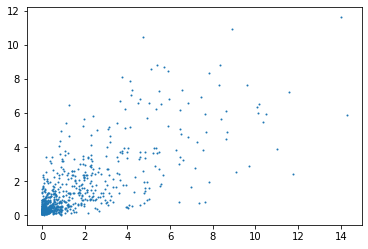

In [35]:
fig, ax = plt.subplots(1)
ax.scatter(Y, yhat_nn, s=1)